# 4. Model Development

## Pre-processing

In [32]:
# Libraries imported for this notebook.

import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV#, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor

In [2]:
# Read Lake_Fictitious_AquaRealTime_Data_Pre_Process_Train into a dataframe, formatted dates, and indexed dates.

mean_df = pd.read_excel('Lake_Fictitious_AquaRealTime_Data_Cleaned_Pre_Process_Train.xlsx', parse_dates=True, index_col=[0])

In [3]:
# Looked at shape

mean_df.shape

(1102, 315)

I defined multiple Xs and ys so I can compare models using the original data to those using the logged and differenced data. I chose to leave the the lagged phycocyanin features in X for the models because autocorrelation may be large part of forecasting phycocyanin.

In [4]:
# Defined Xs and y.
X_lag = mean_df.drop(columns=['phycocyanin_lag_00']).drop(columns=mean_df.filter(like='nl_').columns) # Original metric lags
y_lag = mean_df['phycocyanin_lag_00'] # Target variable, original phycocyanin

X_dif_nl_lag = mean_df.loc[:, mean_df.columns.str.contains('dif_nl_') & ~mean_df.columns.str.contains('dif_nl_phycocyanin_lag_00')] # 1st order differenced, natural logged, and all lag versions of metrics
y_dif_nl_lag = mean_df['dif_nl_phycocyanin_lag_00'] # Target variable, differenced and natural logged phycocyanin

Next, I created a function into which I can enter the features, target variable, type of model, and model name. Each model will be run multiple times starting with including non lagged feature data (_lag_00) and then adding a level of lagged feature data each time it's run. The RMSE with be graphed and the lowest RMSE score from all models will be chosen as the final model.

I used TimeSeriesSplit in the function as a cross-validator because it is specifically designed for time series data. The dataset is split into consecutive folds, where each fold is a superset of the previous one, ensuring that the model is trained on data that retains the temporal nature of time series data.

In [5]:
# Initialized TimeSeriesSplit with number of splits equal to 5

tscv = TimeSeriesSplit(n_splits=5)

The RMSE was calculated to measure the error between the model's predictions and the actual values.

In [6]:
# Created function to run model using increasing number of lags in data

# Created global list to store overall RMSE scores for each lag
overall_rmse_list = []

# Definted function to dynamically generate lag suffixes
def fit_model(X, y, model, model_name, max_lags=20):
    global overall_rmse_list
    
    # Clear the list of overall RMSE scores
    overall_rmse_list.clear()
    
    # Initialize lists to store RMSE values for each lag suffix
    lag_rmse = []
    lag_rmse_std = []  # Store standard deviation of RMSE for error bars
    
    # Iterate through each lag suffix to gradually include more features
    for lag in range(max_lags + 1):  # Start from 0 lags
        lag_features_to_include = [col for col in X.columns if col.endswith("lag_00")]
        
        # Include additional lag features up to the current lag
        for i in range(1, lag + 1):
            lag_suffix = str(i).zfill(2)
            lag_features_to_include += [col for col in X.columns if col.endswith(f"lag_{lag_suffix}")]
        
        overall_rmse_for_suffix = []

        # Iterate through each fold
        tscv = TimeSeriesSplit(n_splits=5)
        for j, (train_index, test_index) in enumerate(tscv.split(X)):
            train_dates = X.index[train_index]
            test_dates = X.index[test_index]

            X_train, X_test = X.loc[train_dates, lag_features_to_include], X.loc[test_dates, lag_features_to_include]
            y_train, y_test = y[train_index], y[test_index]

            # Fit the model on the training data for this fold
            model.fit(X_train, y_train)

            # Make predictions on the testing data for this fold
            y_pred = model.predict(X_test)

            # Calculate RMSE for this fold
            rmse_fold = np.sqrt(mean_squared_error(y_test, y_pred))
            overall_rmse_for_suffix.append(rmse_fold)

        # Calculate and print the overall RMSE for this lag suffix
        overall_rmse = np.mean(overall_rmse_for_suffix)
        lag_rmse.append(overall_rmse)
        
        # Store overall RMSE for this lag in the global list
        overall_rmse_list.append(overall_rmse)
        
        # Calculate standard deviation of RMSE
        lag_rmse_std.append(np.std(overall_rmse_for_suffix))
        
        print(f"RMSE for {model_name} with {lag} lags included: {overall_rmse}")

    # Plotted the RMSE values for each lag suffix with error bars
    plt.errorbar(range(max_lags + 1), lag_rmse, yerr=lag_rmse_std, fmt='o', capsize=5)
    plt.title(f"RMSE for {model_name}")
    plt.xlabel("Number of Lags")
    plt.ylabel("RMSE")
    plt.xticks(range(max_lags + 1))
    plt.grid(True)
    plt.show()

Models capable of making predictions from time series data were essential for this project. I chose to explore linear regression, random forest, and XGBoost models.

## Multivariate Linear Regression

RMSE for linear regression using orginal data with 0 lags included: 110.27582967659976
RMSE for linear regression using orginal data with 1 lags included: 30.319488015331938
RMSE for linear regression using orginal data with 2 lags included: 30.357110655382098
RMSE for linear regression using orginal data with 3 lags included: 29.505445165366403
RMSE for linear regression using orginal data with 4 lags included: 31.415905690806916
RMSE for linear regression using orginal data with 5 lags included: 32.430049754689136
RMSE for linear regression using orginal data with 6 lags included: 33.4162592906096
RMSE for linear regression using orginal data with 7 lags included: 33.47027559503947
RMSE for linear regression using orginal data with 8 lags included: 35.247101038344084
RMSE for linear regression using orginal data with 9 lags included: 38.226300548820255
RMSE for linear regression using orginal data with 10 lags included: 35.39585926053232
RMSE for linear regression using orginal data 

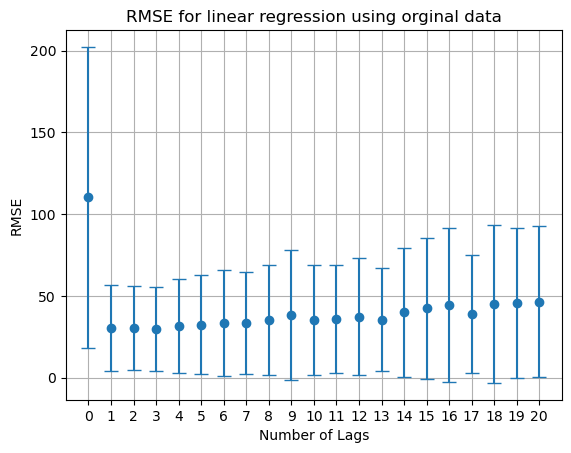

In [15]:
# Used function to run linear regression models using the original metrics and lags.

fit_model(X_lag, y_lag, LinearRegression(), "linear regression using orginal data")

The data indicates that using the original data and the data lagged 1-3 days produces the best linear regression model. A score of 29.5 is approximately 1.8% of the phycocyanin range (medain was 55, mean was 166.73, min was 0.00, and max was 1654.64) which is considered low error. In other words, the error is not worrisome because the median of 55 +/- 29.5 RFU would not constitute a blue green bloom at a dangerous level.

RMSE for Linear regression using transformed data with 0 lags included: 1.6038902637215284
RMSE for Linear regression using transformed data with 1 lags included: 1.9802859788950147
RMSE for Linear regression using transformed data with 2 lags included: 2.0181011980783565
RMSE for Linear regression using transformed data with 3 lags included: 2.1361178705689383
RMSE for Linear regression using transformed data with 4 lags included: 2.3654270752519198
RMSE for Linear regression using transformed data with 5 lags included: 2.6407213751937446
RMSE for Linear regression using transformed data with 6 lags included: 2.637649836907991
RMSE for Linear regression using transformed data with 7 lags included: 2.223682776496937
RMSE for Linear regression using transformed data with 8 lags included: 2.2008705943090354
RMSE for Linear regression using transformed data with 9 lags included: 2.3674133573514915
RMSE for Linear regression using transformed data with 10 lags included: 2.386580067193517
R

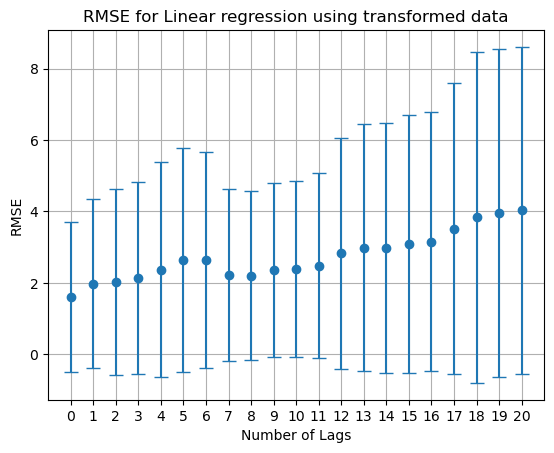

In [16]:
# Used function to run linear regression models using 1st order differenced, natural logged, and all lag versions of metrics.

fit_model(X_dif_nl_lag, y_dif_nl_lag, LinearRegression(), "linear regression using transformed data")

The data indicates that using the transformed data with no lagging produces the best linear regression model.

This RMSE is tronsformed and not directly comparable to the previouse RMSE so I un-natural logged and un-differenced the value.

In [17]:
# Undid natural logarithm transformation on RMSE
rmse_transformed_exp = np.exp(min(overall_rmse_list))

# Undid differencing on RMSE
rmse_back_transformed = rmse_transformed_exp + mean_df['phycocyanin_lag_00'].iloc[-1]

print("Lowest RMSE for transformed data:", min(overall_rmse_list))
print("Back-transformed:", rmse_back_transformed)

Lowest RMSE for transformed data: 1.6038902637215284
Back-transformed: 14.390463555369273


A score of 14.4 is approximately 0.9% of the phycocyanin range which is considered low error. In other words, the error is not worrisome because the median of 55 +/- 14.4 RFU would not constitute a blue green bloom at a dangerous level.

## Random Forest

RMSE for Random forest using original data with 0 lags included: 82.76061516980734
RMSE for Random forest using original data with 1 lags included: 57.09996181985029
RMSE for Random forest using original data with 2 lags included: 50.569950835899036
RMSE for Random forest using original data with 3 lags included: 52.1924620261651
RMSE for Random forest using original data with 4 lags included: 48.98038440572318
RMSE for Random forest using original data with 5 lags included: 49.79491207457794
RMSE for Random forest using original data with 6 lags included: 46.57489417674266
RMSE for Random forest using original data with 7 lags included: 50.87927394007462
RMSE for Random forest using original data with 8 lags included: 47.38500092108563
RMSE for Random forest using original data with 9 lags included: 47.576591190025155
RMSE for Random forest using original data with 10 lags included: 46.76842280083502
RMSE for Random forest using original data with 11 lags included: 48.76854874618027
R

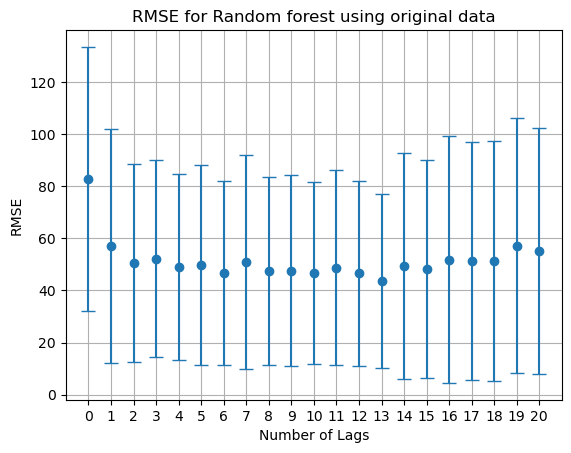

In [18]:
# Used function to run random forest models using the original metrics and lags.

fit_model(X_lag, y_lag, RandomForestRegressor(), "random forest using original data")

The data indicates that using the original data and the data lagged 1-13 days produces the best random forest model. A score of 43.7 is approximately 2.6% of the phycocyanin range which is considered low error. In other words, the error is not worrisome because the median of 55 +/- 43.7 RFU would not constitute a blue green bloom at a dangerous level.

RMSE for Random forest using transformed data with 0 lags included: 1.9389942272171354
RMSE for Random forest using transformed data with 1 lags included: 1.5650082843950255
RMSE for Random forest using transformed data with 2 lags included: 1.4185588511749128
RMSE for Random forest using transformed data with 3 lags included: 1.3911068257525612
RMSE for Random forest using transformed data with 4 lags included: 1.3673748667495282
RMSE for Random forest using transformed data with 5 lags included: 1.3887717304872975
RMSE for Random forest using transformed data with 6 lags included: 1.3977002077630079
RMSE for Random forest using transformed data with 7 lags included: 1.2307852389696918
RMSE for Random forest using transformed data with 8 lags included: 1.2144881774168979
RMSE for Random forest using transformed data with 9 lags included: 1.2457779278992949
RMSE for Random forest using transformed data with 10 lags included: 1.2408090100614302
RMSE for Random forest using transformed d

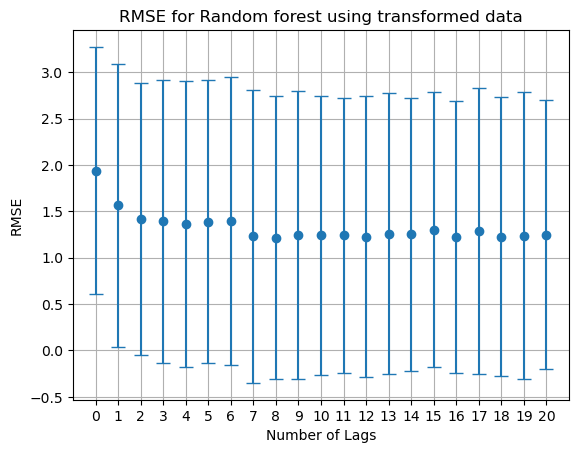

In [19]:
# Used function to run random forest models using 1st order differenced, natural logged, and all lag versions of metrics.

fit_model(X_dif_nl_lag, y_dif_nl_lag, RandomForestRegressor(), "random forest using transformed data")

The data indicates that using the transformed data with 0 to 8 day lagged features produces the best random forest model.

This RMSE is transformed and not directly comparable to the previouse RMSE so I un-natural logged and un-differenced the value.

In [20]:
# Undid natural logarithm transformation on RMSE
rmse_transformed_exp = np.exp(min(overall_rmse_list))

# Undid differencing on RMSE
rmse_back_transformed = rmse_transformed_exp + mean_df['phycocyanin_lag_00'].iloc[-1]

print("Lowest RMSE for transformed data:", min(overall_rmse_list))
print("Back-transformed:", rmse_back_transformed)

Lowest RMSE for transformed data: 1.2144881774168979
Back-transformed: 12.786694513077576


A score of 12.8 is approximately 0.8% of the phycocyanin range which is considered low error. In other words, the error is not worrisome because the median of 55 +/- 12.8 RFU would not constitute a blue green bloom at a dangerous level.

## XGBoost

RMSE for XGBoost using original data with 0 lags included: 112.75100552493106
RMSE for XGBoost using original data with 1 lags included: 92.40667859541209
RMSE for XGBoost using original data with 2 lags included: 93.2246999586298
RMSE for XGBoost using original data with 3 lags included: 87.42503719505206
RMSE for XGBoost using original data with 4 lags included: 88.79533270461775
RMSE for XGBoost using original data with 5 lags included: 86.82720445902095
RMSE for XGBoost using original data with 6 lags included: 87.9437902871063
RMSE for XGBoost using original data with 7 lags included: 87.5950767802116
RMSE for XGBoost using original data with 8 lags included: 87.6100194497991
RMSE for XGBoost using original data with 9 lags included: 87.07644242250191
RMSE for XGBoost using original data with 10 lags included: 86.52563935197101
RMSE for XGBoost using original data with 11 lags included: 83.31052188840943
RMSE for XGBoost using original data with 12 lags included: 82.81493718668546

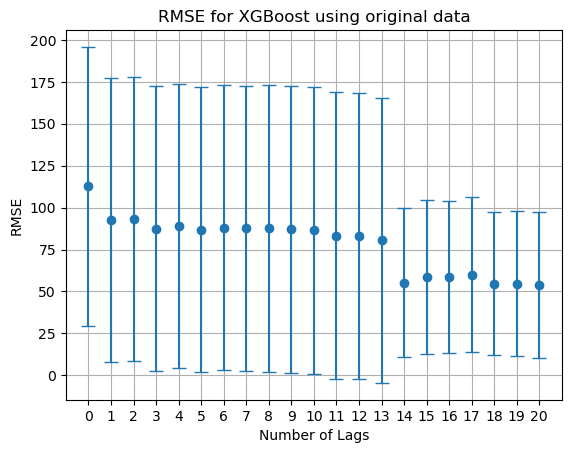

In [21]:
# Used function to run XGBoost models using the original metrics and lags.

fit_model(X_lag, y_lag, xgb.XGBRegressor(), "XGBoost using original data")

The data indicates that using the original data and the data lagged 1-14 days produces the best XGBoost model. Adding more lagged data improves the RMSE slightly but not enough to justify making the dataset more dimensional. A score of 55.3 is approximately 3.3% of the phycocyanin range which is considered low error. In other words, the error is not worrisome because the median of 55 +/- 55.3 RFU would not constitute a blue green bloom at a dangerous level.

RMSE for XGBoost using using transformed data with 0 lags included: 2.330399281230073
RMSE for XGBoost using using transformed data with 1 lags included: 1.7639385853994392
RMSE for XGBoost using using transformed data with 2 lags included: 1.590255123768861
RMSE for XGBoost using using transformed data with 3 lags included: 1.396810804895748
RMSE for XGBoost using using transformed data with 4 lags included: 1.3611512533163188
RMSE for XGBoost using using transformed data with 5 lags included: 1.368101046697308
RMSE for XGBoost using using transformed data with 6 lags included: 1.4451916612307036
RMSE for XGBoost using using transformed data with 7 lags included: 1.2277953258137555
RMSE for XGBoost using using transformed data with 8 lags included: 1.2229678821516716
RMSE for XGBoost using using transformed data with 9 lags included: 1.1583418744698493
RMSE for XGBoost using using transformed data with 10 lags included: 1.1276577321505787
RMSE for XGBoost using using transformed data 

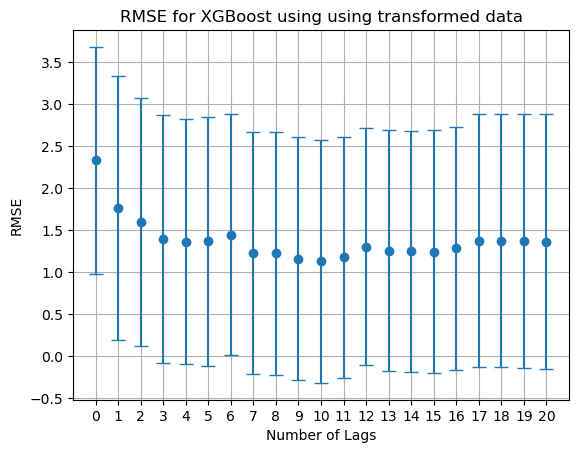

In [22]:
# Used function to run XGBoost models using 1st order differenced, natural logged, and all lag versions of metrics.

fit_model(X_dif_nl_lag, y_dif_nl_lag, xgb.XGBRegressor(), "XGBoost using using transformed data")

The data indicates that using the transformed data with 1-10 day lagged features produces the best XGBoost model.

This RMSE is transformed and not directly comparable to the previouse RMSE so I un-natural logged and un-differenced the value.

In [23]:
# Undid natural logarithm transformation on RMSE
rmse_transformed_exp = np.exp(min(overall_rmse_list))

# Undid differencing on RMSE
rmse_back_transformed = rmse_transformed_exp + mean_df['phycocyanin_lag_00'].iloc[-1]

print("Lowest RMSE for transformed data:", min(overall_rmse_list))
print("Back-transformed:", rmse_back_transformed)

Lowest RMSE for transformed data: 1.1276577321505787
Back-transformed: 12.50653912852979


A score of 12.5 is approximately 0.8% of the phycocyanin range which is considered low error. In other words, the error is not worrisome because the median of 55 +/- 12.5 RFU would not constitute a blue green bloom at a dangerous level. 

Overall, the XGBoost model using the transformed data with 1-10 day lagged features produces the lowest RMSE. I will now define an X for that data and try to tune the hyperparameters.

In [27]:
# Defined X for transformed data up to 10 lags

X_dif_nl_lag_10 = mean_df.loc[:, mean_df.columns.str.contains(r'(00|01|02|03|04|05|06|07|08|09|10)') & 
                           mean_df.columns.str.contains('dif_nl_') & 
                           ~mean_df.columns.str.contains('dif_nl_phycocyanin_lag_00')]

/var/folders/77/lhc9l51s19q1rxd2jv1wfxf40000gn/T/ipykernel_9041/3909372847.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X_dif_nl_lag_10 = mean_df.loc[:, mean_df.columns.str.contains(r'(00|01|02|03|04|05|06|07|08|09|10)') &


In [33]:
# Performed hyperparameter tuning.

# Defined the parameter grid for RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],  # Adjusted for smaller dataset
    'max_depth': [3, 5, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.4, 0.6, 0.8],
    'colsample_bytree': [0.6, 0.8, 1],
    'reg_lambda': [0.01, 0.1, 1],
    'alpha': [0, 0.1, 1]
}

# Initialized overall_rmse_for_suffix list
overall_rmse_for_suffix = []

# Iterated through each fold using TimeSeriesSplit
for j, (train_index, test_index) in enumerate(tscv.split(X_dif_nl_lag_10)):
    train_dates = X_dif_nl_lag_10.index[train_index]
    test_dates = X_dif_nl_lag_10.index[test_index]

    X_train, X_test = X_dif_nl_lag_10.loc[train_dates], X_dif_nl_lag_10.loc[test_dates]
    y_train, y_test = y_dif_nl_lag[train_index], y_dif_nl_lag[test_index]

    # Create XGBoost model without early stopping
    model = XGBRegressor(
        objective='reg:squarederror'
    )

    # Perform RandomizedSearchCV with time series cross-validation
    xg_random = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=tscv)
    xg_random.fit(X_train, y_train)

    # Make predictions on the testing data with the best model
    y_pred = xg_random.best_estimator_.predict(X_test)

    # Calculate RMSE for this fold
    rmse_fold = np.sqrt(mean_squared_error(y_test, y_pred))
    overall_rmse_for_suffix.append(rmse_fold)

# Calculate and print the overall RMSE for this lag suffix
overall_rmse = np.mean(overall_rmse_for_suffix)
std_rmse = np.std(overall_rmse_for_suffix)
print(f"RMSE for XGBoost with lag data of 0-10 days: {overall_rmse} ± {std_rmse}")

RMSE for XGBoost with lag data of 0-10 days: 1.1080360178693902 ± 1.4512870226548296


In [34]:
# Undid natural logarithm transformation on RMSE
rmse_transformed_exp = np.exp(np.mean(overall_rmse_for_suffix))

# Undid differencing on RMSE
rmse_back_transformed = rmse_transformed_exp + mean_df['phycocyanin_lag_00'].iloc[-1]

print("Lowest RMSE for transformed data:", np.mean(overall_rmse_for_suffix))
print("Back-transformed:", rmse_back_transformed)

Lowest RMSE for transformed data: 1.1080360178693902
Back-transformed: 12.446529817044635


## Conclusion

The XGBoost model using the transformed data with 1-10 day lagged features and hypertuning produces the lowest RMSE at 12.4. A score of 12.4 is approximately 0.7% of the phycocyanin range which is considered low error. In other words, the error is not worriesome because the median of 55 +/- 12.4 RFU would not constitute a blue grean bloom at a dangerous level.